In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
from pymsm.multi_state_competing_risks_model import PathObject, MultiStateModel
from pymsm.datasets import prep_ebmt_long
from pymsm.plotting import stackplot, stackplot_state_timesteps, stackplot_state_timesteps_from_paths
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    plot_total_times_ecdf,
    paths_to_timestep_matrix,
    get_state_timestep_probs
)

%load_ext autoreload
%autoreload 2

# The EBMT dataset  
Data from the European Society for Blood and Marrow Transplantation (EBMT)  
  
  
A data frame of 2279 patients transplanted at the EBMT between 1985 and 1998.
(from R mstate package, see: https://www.rdocumentation.org/packages/mstate/versions/0.3.1/topics/EBMT%20data)  


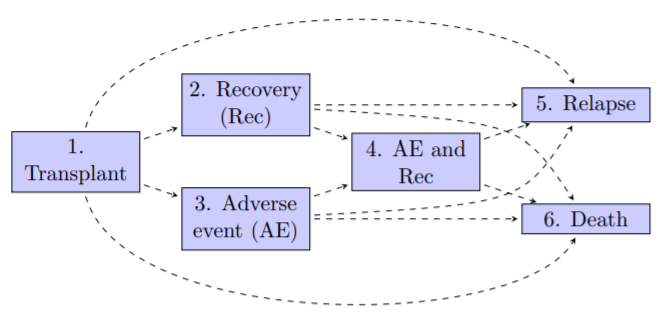

In [2]:
from IPython.display import Image
Image(filename="ebmt_states.png")

In [3]:
competing_risk_dataset, covariate_cols, states_labels = prep_ebmt_long()
competing_risk_dataset.head()

,sample_id,origin_state,target_state,time_entry_to_origin,time_transition_to_target,match_no gender mismatch,proph_yes,year_1990-1994,year_1995-1998,agecl_<=20,agecl_>40
0,1,1,2,0.0,22.0,1,0,0,1,0,0
1,1,2,0,22.0,995.0,1,0,0,1,0,0
2,2,1,3,0.0,12.0,1,0,0,1,0,0
3,2,3,4,12.0,29.0,1,0,0,1,0,0
4,2,4,5,29.0,422.0,1,0,0,1,0,0


# Peak at some transitions

C:\Users\Admin\anaconda3\lib\site-packages\lifelines\fitters\aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


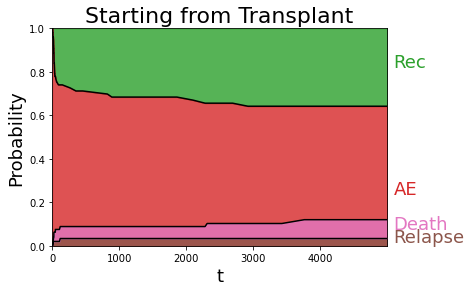

In [4]:
origin_state = 1
stackplot_data = competing_risk_dataset[
    competing_risk_dataset["origin_state"] == origin_state
].sample(100)

stackplot(
    data=stackplot_data,
    origin_state=origin_state,
    duration_col="time_transition_to_target",
    event_col="target_state",
    order_top=[2, 3],
    order_bottom=[5, 6],
    labels=states_labels,
)


C:\Users\Admin\anaconda3\lib\site-packages\lifelines\fitters\aalen_johansen_fitter.py:111: Warning: Tied event times were detected. The Aalen-Johansen estimator cannot handle tied event times.
                To resolve ties, data is randomly jittered.
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\lifelines\fitters\__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


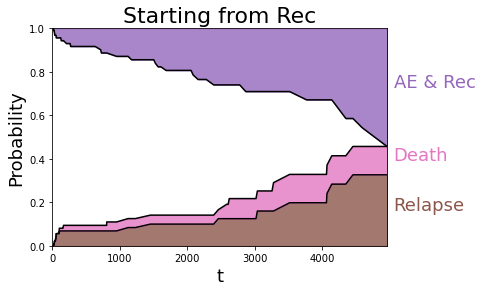

In [5]:
origin_state = 2
stackplot_data = competing_risk_dataset[
    competing_risk_dataset["origin_state"] == origin_state
].sample(100)

stackplot(
    data=stackplot_data,
    origin_state=origin_state,
    duration_col="time_transition_to_target",
    event_col="target_state",
    order_top=[4],
    order_bottom=[5, 6],
    labels=states_labels,
)


# Fit MSM

In [6]:
from pymsm.event_specific_fitter import SurvivalTreeWrapper

def default_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    return covariates_entering_origin_state


terminal_states = [5, 6]


multi_state_model = MultiStateModel(
    competing_risk_dataset,
    terminal_states,
    default_update_covariates_function,
    covariate_cols,
    event_specific_fitter=SurvivalTreeWrapper,
    competing_risk_data_format=True,
)


multi_state_model.fit()


Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 785
>>> Fitting Transition to State: 3, n events: 907
>>> Fitting Transition to State: 5, n events: 95
>>> Fitting Transition to State: 6, n events: 160
Fitting Model at State: 2
>>> Fitting Transition to State: 5, n events: 112
>>> Fitting Transition to State: 6, n events: 39
>>> Fitting Transition to State: 4, n events: 227
Fitting Model at State: 3
>>> Fitting Transition to State: 4, n events: 433
>>> Fitting Transition to State: 6, n events: 197
>>> Fitting Transition to State: 5, n events: 56
Fitting Model at State: 4
>>> Fitting Transition to State: 5, n events: 107
>>> Fitting Transition to State: 6, n events: 137


# Single patient statistics

In [7]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=competing_risk_dataset.loc[0, covariate_cols].values,
    origin_state=1,
    current_time=0,
    n_random_samples=1000,
    max_transitions=10,
)

# for mc_path in mc_paths:
#     states = mc_path.states
#     time_at_each_state = mc_path.time_at_each_state
#     print(states)
#     print(time_at_each_state)


In [8]:
all_states = competing_risk_dataset["target_state"].unique()
# Probability of visiting any of the states
for state in all_states:
    if state == 0:
        continue
    print(
        f"Probabilty of {states_labels[state]} = {prob_visited_states(mc_paths, states=[state])}"
    )

# Probability of terminal states - Death and Relapse
print(
    f"Probabilty of any terminal state = {prob_visited_states(mc_paths, states=multi_state_model.terminal_states)}"
)



Probabilty of Rec = 0.546
Probabilty of AE = 0.331
Probabilty of AE & Rec = 0.68
Probabilty of Relapse = 0.307
Probabilty of Death = 0.693
Probabilty of any terminal state = 1.0


In [9]:
# Stats for times at states
dfs = []
for state in all_states:
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[states_labels[state]],
        )
    )
pd.concat(dfs)


,time_in_state_mean,time_in_state_std,time_in_state_median,time_in_state_min,time_in_state_max,time_in_state_quantile_0.1,time_in_state_quantile_0.25,time_in_state_quantile_0.75,time_in_state_quantile_0.9
Rec,100.824495,492.532843,2.999960,0.0,4238.999935,0.0,0.0,21.000012,61.099967
AE,53.422467,263.668767,0.000000,0.0,3873.999918,0.0,0.0,11.249999,93.999955
AE & Rec,975.464979,1551.985968,136.999961,0.0,4762.999981,0.0,0.0,1076.749930,4179.099944


(-0.5, 100.0)

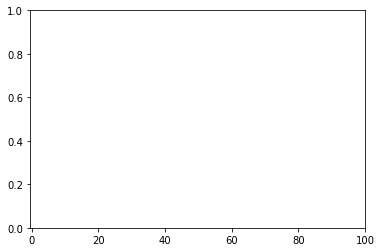

In [10]:
# CDF of  time in "adverse event" state
fig, ax = plt.subplots()
plot_total_times_ecdf(mc_paths, states=[3], ax=ax)
ax.set_xlim(-0.5, 100)



# Multiple runs stats

timestep_matrix
 [[1 2 2 3 0]
 [1 1 2 2 3]
 [1 1 5 5 5]]
state_timestep_probs



{1: array([1.        , 0.66666667, 0.        , 0.        , 0.        ]),
 2: array([0.        , 0.33333333, 0.66666667, 0.33333333, 0.        ]),
 3: array([0.        , 0.        , 0.        , 0.33333333, 0.5       ]),
 5: array([0.        , 0.        , 0.33333333, 0.33333333, 0.5       ])}

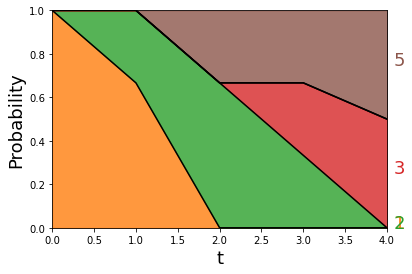

In [11]:
# Test scenario

test_paths = [
    PathObject(states=[1, 2, 3], time_at_each_state=[1, 2, 1]),
    PathObject(states=[1, 2, 3], time_at_each_state=[2, 2, 1]),
    PathObject(states=[1, 5], time_at_each_state=[2]),
]
true_timestep_matrix = np.array([[1, 2, 2, 3, 0], [1, 1, 2, 2, 3], [1, 1, 5, 5, 5]])
max_timestep = 5
timestep_matrix = paths_to_timestep_matrix(test_paths, max_timestep)
print("timestep_matrix\n", timestep_matrix)

state_timestep_probs = get_state_timestep_probs(timestep_matrix)
print("state_timestep_probs\n")


stackplot_state_timesteps(state_timestep_probs, order_top=[5], order_bottom=[1, 2, 3,])

state_timestep_probs


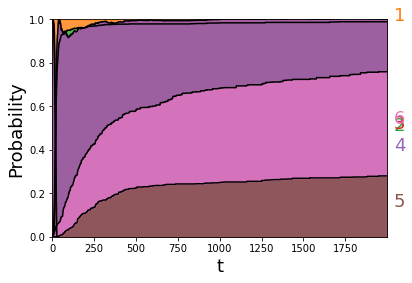

In [12]:
max_timestep = 2000
stackplot_state_timesteps_from_paths(
    mc_paths, max_timestep, order_top=[1, 2, 3, 4], order_bottom=[5, 6]
)